# Vehicle Detection Project

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.ndimage.measurements import label
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Load Car and non-car data

In [2]:
# images are divided up into vehicles and non-vehicles

car_images = glob.glob('vehicles/*/*.png')
noncar_images = glob.glob('non-vehicles/*/*.png')
cars = []
notcars = []

for image in car_images:
    cars.append(image)
    
for image in noncar_images:
    notcars.append(image)
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


## Visualize Car and Non-Car Data

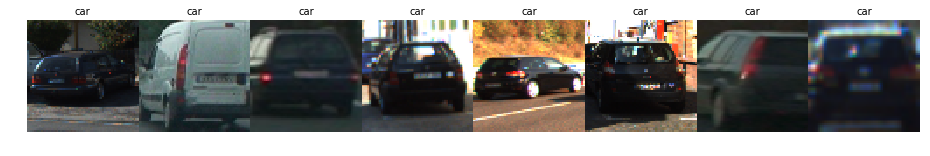

In [3]:
fig, axs = plt.subplots(1,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .002, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(0, 8):
    img = cv2.imread(car_images[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
plt.show()

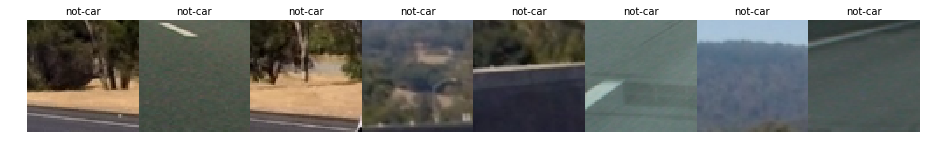

In [4]:
fig, axs = plt.subplots(1,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .002, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(0,8):
    img = cv2.imread(noncar_images[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not-car', fontsize=10)
    axs[i].imshow(img)
plt.show()

## Extract HOG features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Visualize HOG Feature

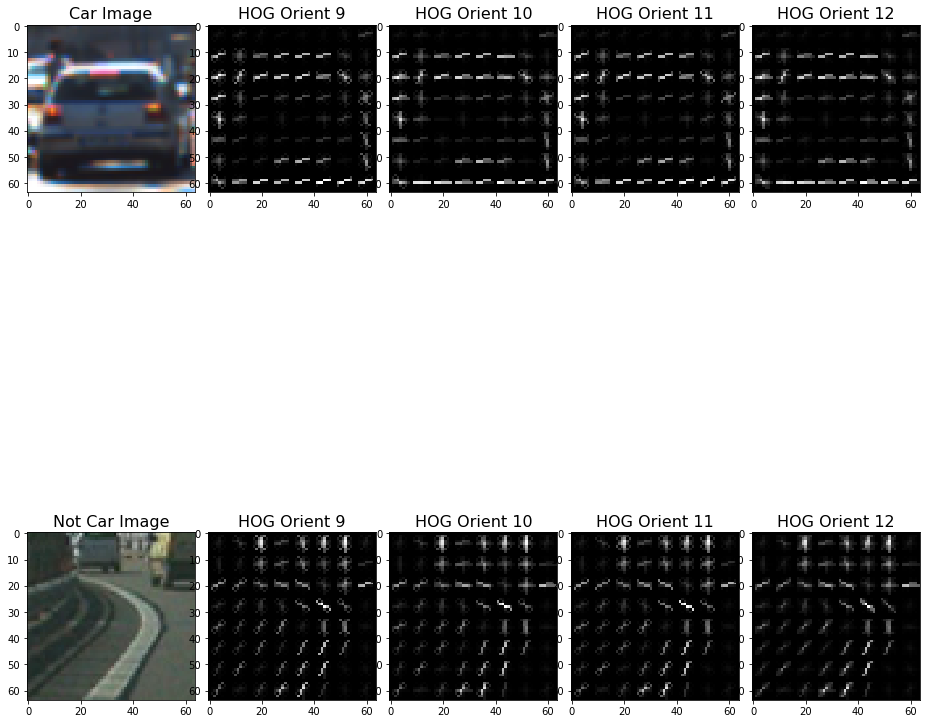

In [6]:
carimg = mpimg.imread(cars[np.random.randint(0,len(cars))])
car_img = cv2.cvtColor(carimg, cv2.COLOR_RGB2YCrCb)
fet_car9, car_9 = get_hog_features(car_img[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
fet_car10, car_10 = get_hog_features(car_img[:,:,0], 10, 8, 2, vis=True, feature_vec=True)
fet_car11, car_11 = get_hog_features(car_img[:,:,0], 11, 8, 2, vis=True, feature_vec=True)
fet_car12, car_12 = get_hog_features(car_img[:,:,0], 12, 8, 2, vis=True, feature_vec=True)

notcarimg = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
notcar_img = cv2.cvtColor(notcarimg, cv2.COLOR_RGB2YCrCb)
fet_notcar9, notcar_9 = get_hog_features(notcar_img[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
fet_notcar10, notcar_10 = get_hog_features(notcar_img[:,:,0], 10, 8, 2, vis=True, feature_vec=True)
fet_notcar11, notcar_11 = get_hog_features(notcar_img[:,:,0], 11, 8, 2, vis=True, feature_vec=True)
fet_notcar12, notcar_12 = get_hog_features(notcar_img[:,:,0], 12, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(16,16))
f.subplots_adjust(hspace = .4, wspace=.08)
ax1.imshow(carimg)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_9, cmap='gray')
ax2.set_title('HOG Orient 9', fontsize=16)
ax3.imshow(car_10, cmap='gray')
ax3.set_title('HOG Orient 10', fontsize=16)
ax4.imshow(car_11, cmap='gray')
ax4.set_title('HOG Orient 11', fontsize=16)
ax5.imshow(car_12, cmap='gray')
ax5.set_title('HOG Orient 12', fontsize=16)

ax6.imshow(notcarimg)
ax6.set_title('Not Car Image', fontsize=16)
ax7.imshow(notcar_9, cmap='gray')
ax7.set_title('HOG Orient 9', fontsize=16)
ax8.imshow(notcar_10, cmap='gray')
ax8.set_title('HOG Orient 10', fontsize=16)
ax9.imshow(notcar_11, cmap='gray')
ax9.set_title('HOG Orient 11', fontsize=16)
ax10.imshow(notcar_12, cmap='gray')
ax10.set_title('HOG Orient 12', fontsize=16)
plt.show()

## Spatial Binning of Color

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

## Visualize Spatial Binning

Spatial Bining Feature Vectore Length (3072,)


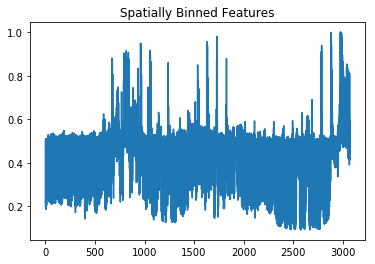

In [8]:
feature_vec = bin_spatial(car_img, size=(32, 32))
print('Spatial Bining Feature Vectore Length', feature_vec.shape)
# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

## Histograms of Color

In [9]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256), com=True):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    if com==True:
        # Concatenate the histograms into a single feature vector
        return hist_features
    else:
         # Return the individual histograms, bin_centers and feature vector
        return channel1_hist, channel2_hist, channel3_hist, bin_centers

## Extract HOG, Spatial Binning & Histogram of Color Features for Car and Non-Car Images

In [10]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, com=True)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Feature Extraction Parameters

In [11]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

### Extract Features for Input Datasets

In [12]:
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract car features...')

t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract not car features...')

40.55 Seconds to extract car features...
40.79 Seconds to extract not car features...


### Combine the Features

In [13]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### Dump/Save the Scaler 

In [14]:
with open('scaler.pkl', 'wb') as scaler:
    pickle.dump(X_scaler, scaler)

### Shuffle and Split the data in training and test & Train the Classifier

In [38]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
t=time.time()
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t2 =time.time()
print(round(t2-t, 2), 'Seconds to predict...')

Using: 9 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 4896
12.13 Seconds to train SVC...
Test Accuracy of SVC =  0.9901
0.02 Seconds to predict...


### Dump/Save the Classifier

In [16]:
# now you can save it to a file
with open('classifier.pkl', 'wb') as clf:
    pickle.dump(svc, clf)

### To Draw Rectangles on Image

In [17]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### To find Cars in an image

In [18]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    if hog_channel == "ALL":
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else:
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    window_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return window_list

### Visualize the area to be searched to detect cars 

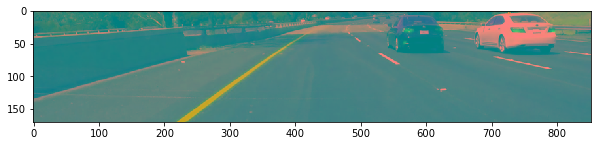

In [19]:
img = mpimg.imread('test_images/test6.jpg')

draw_img = np.copy(img)
# img = img.astype(np.float32)/255

scale = 1.5
img_tosearch = img[400:656,:,:]

ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
imshape = ctrans_tosearch.shape
ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
plt.figure(figsize=(10,10))
plt.imshow(ctrans_tosearch)
plt.show()

In [20]:
svc = pickle.load( open( "classifier.pkl", "rb" ) )

In [21]:
X_scaler = pickle.load( open( "scaler.pkl", "rb" ) )

### Visualize Find Cars in image using different scale values

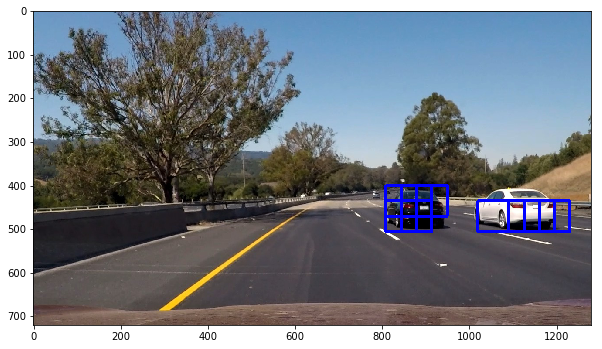

9 rectangles with cars found in image - 1.1  Scale Value


In [22]:
ystart = 400
ystop = 660
scale = 1.1
    
hot_windows1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img = draw_boxes(img, hot_windows1, color=(0, 0, 255), thick=6)    
plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.show()

print(len(hot_windows1), 'rectangles with cars found in image -', scale, ' Scale Value')

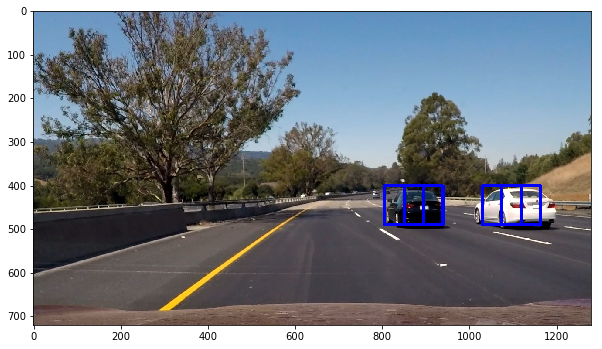

4 rectangles with cars found in image - 1.4  Scale Value


In [23]:
ystart = 400
ystop = 660
scale = 1.4
    
hot_windows2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img = draw_boxes(img, hot_windows2, color=(0, 0, 255), thick=6)         
plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.show()

print(len(hot_windows2), 'rectangles with cars found in image -', scale, ' Scale Value')

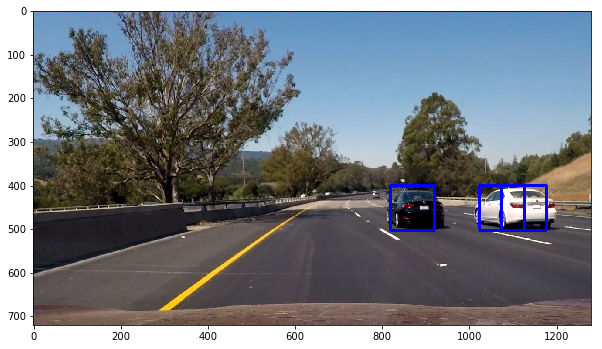

3 rectangles with cars found in image - 1.6  Scale Value


In [24]:
ystart = 400
ystop = 660
scale = 1.6
    
hot_windows3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img = draw_boxes(img, hot_windows3, color=(0, 0, 255), thick=6)         
plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.show()

print(len(hot_windows3), 'rectangles with cars found in image -', scale, ' Scale Value')

### Visualize combining various window sliding search

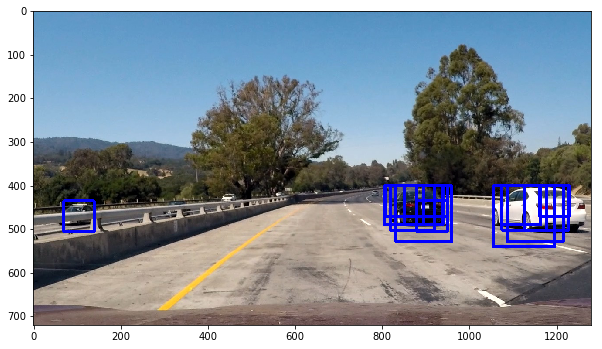

In [25]:
img = mpimg.imread('test_images/test1.jpg')

rectangles = []
    
scales = [1.1, 1.4, 1.6, 2.0, 2.2, 2.4, 3.0]
pos = [(400,550), (400,600), (400, 600), (400, 660), (400, 660), (400, 660), (400, 660)]
    
heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
for i in range(0,len(scales)):
    scale = scales[i]
    ystart = pos[i][0]
    ystop = pos[i][1]
    hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)  
    rectangles.append(hot_windows)
   
rects = [item for sublist in rectangles for item in sublist]

test_img_rects = draw_boxes(img, rects)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.show()

### Apply Heatmap

In [26]:
def actual_heat(heatmap, bbox_list):
    """
    This heat function is only used for visualization purpose
    """
    for i in range(0, len(bbox_list)):
        box_list = bbox_list[i]
        # Iterate through  list of bboxes
        for box in box_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [27]:
def add_heat(heatmap, box_list):
    """
    This heat function is the final and modified implementation of a original heat function
    """
    for i in range(0, len(box_list)):
        bbox_list = box_list[i]
        # Iterate through list of bboxes
        for j in range(0, len(bbox_list)):
            bbbox_list = bbox_list[j]
            for box in bbbox_list:
                # Add += 1 for all pixels inside each bbox
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))()
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

### Visualize Heatmap

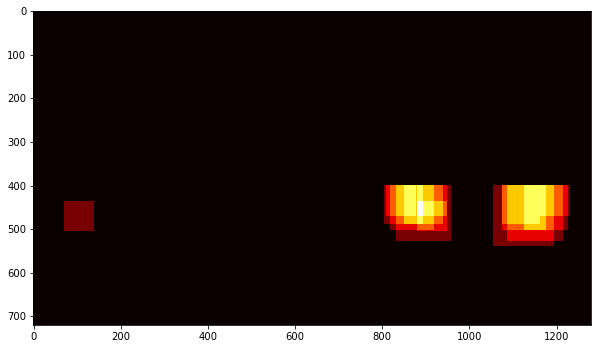

In [28]:
# Test out the heatmap
heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = actual_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

### Apply Threshold Value for Heat

In [29]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

### Visualize Threshold on heatmap

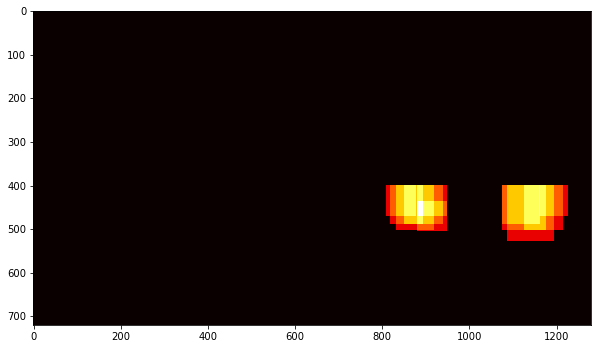

In [30]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')
plt.show()

### Visualizaton and application of Labels on Heatmap

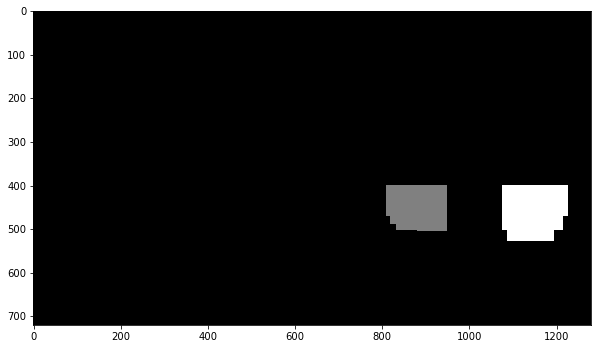

2 cars found


In [31]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.show()
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

In [32]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Visualize bounding boxes

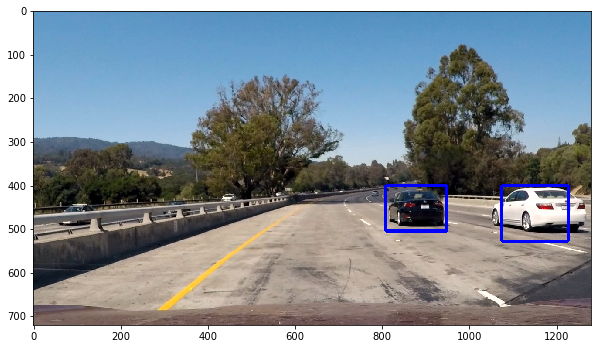

In [33]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.show()

### Windows Class to store the rectangles where the cars were detected during each frame

In [34]:
class Windows():
    """
    The Windows class stores the rectangles detected during each frame/image
        This classe is basically used to smooth out the video output
    """
    def __init__(self):       
        # was the lines detected correctly in the last iteration?
        self.wind = []
        self.count = 0
        
    def add_win(self, win):
        """
        The function stores the last 10 frames/images of video for smoothing the output
        """
        num_frames = 10
        self.wind.append(win)
        if len(self.wind) > num_frames:
            self.wind = self.wind[1:]  
            
    def get_win(self):           
        return self.wind
    
    def frame_count(self):
        self.count += 1

### Combining all together in Pipeline function to process Image

In [35]:
def Pipeline(img):
   
    rectangles = []
    
    #Scale Values
    scales = [1.1, 1.4, 1.6, 2.0, 2.2, 2.4, 3.0]
    #Corresponding Positions where scale values to be applied for searching cars
    pos = [(400,550), (400,600), (400, 600), (400, 660), (400, 660), (400, 660), (400, 660)]
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    #iterate through all the window sizes
    for i in range(0,len(scales)):
        scale = scales[i]
        ystart = pos[i][0]
        ystop = pos[i][1]
        hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)  
        #win.add_win(hot_windows)
        rectangles.append(hot_windows)
   
    #Add the detected car rectangles to the window object
    win.add_win(rectangles)
    
    # Get the last detections
    win_pos = win.get_win()
    
    #Threshold Value
    thresh_val = 1 + len(win_pos)//2
    
    # Add heat to each box in box list
    heat = add_heat(heat, win_pos)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, thresh_val)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    #Create Heatmap
    X = int(300)
    Y = int(200)
    new_heat = cv2.resize(heat, (X, Y ))
    heat_img = cv2.resize(img, (X, Y ))
    heat_img_gray = cv2.cvtColor(heat_img , cv2.COLOR_RGB2GRAY)
    
    heat_off = (new_heat/np.max(new_heat)*255).astype(int)    
    
    heat_img_gray_R = heat_img_gray
    heat_img_gray_R[(new_heat>0)] =255
    heat_img_gray_G = heat_img_gray
    heat_img_gray_G[(new_heat>0)] =0
    heat_img_gray_B = heat_img_gray
    heat_img_gray_B[(new_heat>0)] =0
    
    draw_img[0:Y ,0:X,0]=heat_img_gray_R + heat_off
    draw_img[0:Y ,0:X,1]=heat_img_gray_G
    draw_img[0:Y ,0:X,2]=heat_img_gray_B
    
    return draw_img

### Process Video

In [40]:
directory = "test_videos_output"
if not os.path.exists(directory):
    os.makedirs(directory)
    
write_output = 'test_videos_output/project_video_out.mp4'

win = Windows()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video_out.mp4
[MoviePy] Writing video test_videos_output/project_video_out.mp4


100%|█████████▉| 1260/1261 [13:25<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_out.mp4 

CPU times: user 22min 46s, sys: 10 s, total: 22min 56s
Wall time: 13min 25s
